<center> <h1 style="background-color:DarkSlateGray; color:white" >A/B Testing for a Cute Mobile Game</h1> 

<center><img
src="https://tactilegames.com/wp-content/uploads/2018/05/cookie-cats.png" style="width:40%;height:40%;">
</center>
    
<br>    



Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

**As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds**.

**Let's Start!**

<h3 style="color:DarkSlateGray" >1. PACKAGES</h3>

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy.stats import shapiro,levene, ttest_ind, mannwhitneyu
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

<h3 style="color:DarkSlateGray" >2. DATA</h3>

In [2]:
path = "../input/mobile-games-ab-testing/cookie_cats.csv"
df_ab = pd.read_csv(path)
df_ab.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())

check_df(df_ab)

##################### Shape #####################
(90189, 5)
##################### Types #####################
userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object
##################### Head #####################
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
##################### Tail #####################
        userid  version  sum_gamerounds  retention_1  retention_7
90186  9999710  gate_30              28         True        False
90187  9999768  gate_40              51         True        False
90188  9999861  gate_40              16        False        False
##################### NA #####################
userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7      

<h3 style="color:DarkSlateGray" >3. SUMMARY STATS</h3>

In [4]:
# Number of Unique User
print(df_ab.userid.nunique() == df_ab.shape[0])
# Summary Stats: sum_gamerounds
df_ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

True


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,49854.0000


In [5]:
# A/B Groups - Target Summary Stats
df_ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,52.4563,256.7164,49854
gate_40,45489,16.0000,51.2988,103.2944,2640


<h3 style="color:DarkSlateGray" >4. OUTLIERS</h3>

In [6]:
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

# Check Outliers
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

check_outlier(df_ab, "sum_gamerounds")

True

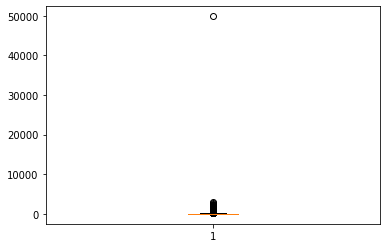

In [7]:
plt.figure(figsize=(6,4))
plt.boxplot(df_ab["sum_gamerounds"])
plt.show()

In [8]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(df_ab, "sum_gamerounds")

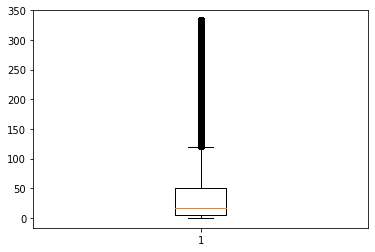

In [9]:
plt.figure(figsize=(6,4))
plt.boxplot(df_ab["sum_gamerounds"])
plt.show()

<h3 style="color:DarkSlateGray" >5. SOME OBSERVATIONS & COMMENTS</h3>

In [10]:
df_ab.groupby("sum_gamerounds").userid.agg("count").head()

sum_gamerounds
0.0000    3994
1.0000    5538
2.0000    4606
3.0000    3958
4.0000    3629
Name: userid, dtype: int64

**3994 users never played the game and too many people playing the game too few , but why ?**

Maybe , this users have no free time to play game.
Maybe they don't like the game so prefer to download other games or they play different games.

**What can be done ?**

Tactile Entertainment should learn why users churn playing the game.
Doing research and collecting data about the game stages and make detailed analysis.
The difficulty of the game can be measured.
In-game incentives and gifts can be given by reminding them again with notifications.

In [11]:
# Users reached gate 30 & gate 40 levels
df_ab.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

**gate_30 and gate_40 are our control and Test groups. They seem similar, but are the two groups statistically significant?** 

We will investigate that the two groups statistically significant or not.

In [12]:
df_ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "max"])

,count,median,mean,max
version,,,,
gate_30,44700,17.0000,46.5870,333.5000
gate_40,45489,16.0000,46.3768,333.5000


In [13]:
df_retention = pd.DataFrame({"RET1_COUNT": df_ab["retention_1"].value_counts(),
              "RET7_COUNT": df_ab["retention_7"].value_counts(),
              "RET1_RATIO": df_ab["retention_1"].value_counts() / len(df_ab),
              "RET7_RATIO": df_ab["retention_7"].value_counts() / len(df_ab)})
df_retention

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50036,73408,0.5548,0.8139
True,40153,16781,0.4452,0.1861


**55 percent of the players didn't play the game 1 day  &  81 percent of the players didn't play the game 7 day after installing**

In [14]:
df_ab["Retention"] = np.where((df_ab.retention_1 == True) & (df_ab.retention_7 == True), 1,0)
df_ab.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "max"])

count   median     mean      max
version Retention                                  
gate_30 0          38024  12.0000  27.6288 333.5000
        1           6676 127.0000 154.5658 333.5000
gate_40 0          38983  12.0000  27.6771 333.5000
        1           6506 133.0000 158.4227 333.5000

**The summary statistics are similar here as well.**

<h3 style="color:DarkSlateGray" >6. A/B TESTING</h3>

In [15]:
# Defining A/B groups
df_ab["version"] = np.where(df_ab.version == "gate_30", "A", "B")
df_ab.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7,Retention
0,116,A,3.0000,False,False,0
1,337,A,38.0000,True,False,0
2,377,B,165.0000,True,False,0
3,483,B,1.0000,False,False,0
4,488,B,179.0000,True,True,1
5,540,B,187.0000,True,True,1
6,1066,A,0.0000,False,False,0
7,1444,B,2.0000,False,False,0
8,1574,B,108.0000,True,True,1
9,1587,B,153.0000,True,False,0


Test Stat = 0.6361, p-value = 0.0000


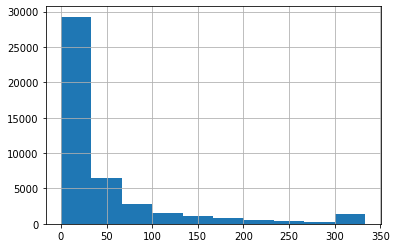

In [16]:
test_stat, pvalue = shapiro(df_ab.loc[df_ab["version"] == "A", "sum_gamerounds"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))
df_ab.loc[df_ab["version"] == "A", "sum_gamerounds"].hist()
plt.show()

Test Stat = 0.6388, p-value = 0.0000


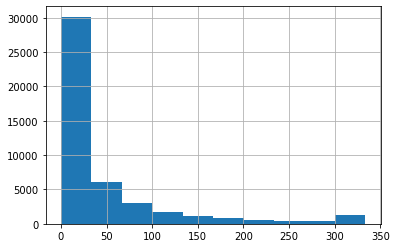

In [17]:
test_stat, pvalue = shapiro(df_ab.loc[df_ab["version"] == "B", "sum_gamerounds"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))
df_ab.loc[df_ab["version"] == "B", "sum_gamerounds"].hist()
plt.show()

**As we see p value < 0.05 and non parametric , H0 Rejected , we will use mannwhitneyu.**

In [18]:
test_stat, pvalue = mannwhitneyu(df_ab.loc[df_ab["version"] == "A", "sum_gamerounds"].dropna(),
                                 df_ab.loc[df_ab["version"] == "B", "sum_gamerounds"].dropna())
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 1024339918.5000, p-value = 0.0499


<h3 style="color:DarkSlateGray" >7. FINAL & CONCLUSION</h3>

**p value < 0.05 , Mann Whitney U Testing also rejected H0 hypothesis and we learned A/B groups are not similar.**

There are statistically significant difference between two groups about moving first gate from level 30 to level 40 for game rounds.

In [19]:
df_ab.groupby("version").retention_1.mean(), df_ab.groupby("version").retention_7.mean()

(version
 A   0.4482
 B   0.4423
 Name: retention_1, dtype: float64,
 version
 A   0.1902
 B   0.1820
 Name: retention_7, dtype: float64)

**Although the results are very close, there is a slight advantage to staying at the gate-30.**


I hope it was useful. If you like it, I'd be very happy if you could **Upvote**. 

Thanks , stay with Data!